In [1]:
"""
Ipython notebook to test/document function that loads
a single PRMS parameter from the parameter file to a into a numpy array
John Volk, Mar 2015
Python 2.7.7
"""
import os
import matplotlib.pyplot as plt
from __future__ import print_function

% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def loadfile(file_path):
    """
    Read a text file and loard into a list that contains all lines in the file
    Arguments:
        file_path (str): path to (param) file
    Returns:
        param_lines (list): list that contains each line in the file

    """
    with open(file_path, 'r') as paramdata:
        param_lines = paramdata.readlines()
    return param_lines

In [3]:
def load_param(param_file,param_name):
    """
    Read a the param file and retrieve the values of the parameter that is being searched for as a 1-D 
    ndarray. 
    
    Arguments:
        param_file (str): path to param file
        param_name (str): name of the parameter that is being retrieved from the parameter file
    Returns:
        param_data (numpy.ndarray): one dimensional array containing the paraemter values for the parameter 
            (param_name). 
    """
    import numpy as np
    lines = loadfile(param_file) # load all lines into memory
    starti = -1 # initiate index of line where param is found
    for i,line in enumerate(lines):
        if param_name == line.split()[0]:
            starti = i
            try:  ## convert the number of dimes to a string and check that it is after the param_name line
                dims = str(lines[starti +1].strip()) 
            except:
                print('There was an error reading the dimension info for {}'.format(param_name))
                break
            
            if dims == '1': ## number of dimensions
                try:
                    param_dim = str(lines[starti +2].strip()) # name of dimension
                    ndims = int(lines[starti +3].strip()) # length of dimensions
                    datatype = int(lines[starti+4].strip()) # datatype (1=int, 2=float, 4-str)
                except:
                    print('There was an error reading the dimension info for {}'.format(param_name))
                    break                        
                print ('Parameter: ' ,param_name)
                print ('Dimension: ' , param_dim)
                print ('Number of dimensions: ' , ndims)
                if param_dim != "nhru" and param_dim != 'nmonths' and param_dim != 'one':
                    ## this is going to change, we will allow for retrieiving parameters of any valid dimensions
                    print ('Sorry {} is not a parameter I was programmed to change!'.format(param_name))
                    break
                data_start = starti + 5  ## skip five lines to data start
                data_end = data_start + ndims
                param_data = lines[data_start:data_end] ## get slice of lines that contains data
                param_data = np.array(param_data) ## convert to np array (will be of type (str) including newlines)
                return param_data.astype(float) ## convert array datatype to float
                break
                
            ##In case the parameter is two dimensional (snow rain adjust, etc)    
            elif dims == '2':
                try:
                    param_dim1 = str(lines[starti +2].strip()) 
                    param_dim2 = str(lines[starti +3].strip()) 
                    ndims = int(lines[starti +4].strip())
                    datatype = int(lines[starti+5].strip())
                except:
                    print ('There was an error reading the dimension info for {}'.format(param_name))
                    break
                print ('Parameter: ' ,param_name)
                print ('Dimensions: {} by {}'.format(param_dim1, param_dim2))
                print ('Number of dimensions: ' , ndims)
                data_start = starti + 6 ## skip six lines to data start
                data_end = data_start + ndims
                param_data = lines[data_start:data_end]
                param_data = np.array(param_data)
                return param_data.astype(float) 
                break
            else:
                print('The parameter {} has the wrong number of dimensions'.format(param_name))
                break
    if starti == -1:
        print ('The parameter {} was not found in the file'.format(param_name))

In [4]:
def load_param_dimensions(param_file):
    """
    Read a the param file and retrieve the names and lengths of all parameter dimensions that are in the file,
    return the data as a Python dictionary of name-length pairs.    
    Arguments:
        param_file (str): path to param file.
    Returns:
        dims (dict): dictionary containing parameter dimension names as keys and associated interger lengths
            as values.
    """
    dims = dict()
    data_start = False
    with open(param_file,'r') as f:
        for i,line in enumerate(f):
            if '** Parameters **' in line: break
            if '** Dimensions **' in line: 
                data_start = True
                continue
            if '#' in line and data_start: 
                tmp_ind = i
                continue
            if data_start:
                if i == tmp_ind+1: tmp_dim_name = line.rstrip() 
                elif i == tmp_ind+2: 
                    tmp_dim_len = int(line.rstrip())
                    dims[tmp_dim_name] = tmp_dim_len
    return dims

## set file path and parameter name for example

In [5]:
## set parameter file path
inf = os.path.join(os.getcwd(),'..','models/lbcd/lbcd.param')  ## parameter file we will use for this example
## load paramter into 1-d array
p = load_param(inf, 'tmax_adj')
hrutype = load_param(inf, 'hru_type')

Parameter:  tmax_adj
Dimension:  nhru
Number of dimensions:  10791
Parameter:  hru_type
Dimension:  nhru
Number of dimensions:  10791


<matplotlib.colorbar.Colorbar instance at 0x7fa428456320>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


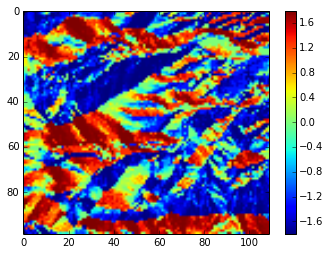

In [6]:
## see if it makes sense:
## tmax_adj is a spatial parameter that adjusts the temperature distributino for each HRU to account for 
## spatial information such as topographic aspect
#### number of rows and cols in PRMS model
nrows = 99
ncols = 109
## test plot
p.shape = nrows,ncols ## reshape spatial parameter because this parameters dimention is nhru
plt.imshow(p)
plt.colorbar()

## Issues and how they can be addressed:
* Needs to be able to read parameters of any PRMS dimensions, this can be accomplished by reading the dimensions at the top of the parameter file or by having prms print out a file with all possible dimensions- the first method is preferable because if the user did not put the dimensions in the parameter file and if they were not valid PRMS dimensiosn then their model would not run anyway.  

**partially resolved- see below**
* Although the current version of PRMS does not have any parameters that are 3 dimensional or larger the code should be more flexible, currently the function would print that the parameter has the wrong number of dimensions if the parameter was 3-D or larger. This can be done since the number of dimensiosn are already being read, after the dimension names are listed the rest of each parameters metadata is still listed in the same order line by line regardless of how many dimensions. By allowing this to be more felixible the function would work in the future case that PRMS incorporates new parameters that are higher than two dimensional.
* Currently this function reads the entire files lines into memory, goes through the lines and finds the slice of lines that has the parameter's values and returns it. There is probably a more efficient way to do this although I am not sure how important it is to optimize the memory use. I can see this being an issue with very large PRMS models- ones that have over 100,000 HRUs. In that case the param file may be over 100 mb. 
* The function should first look up from a table whether or not the parameter that is being searched is a valid PRMS parameter as opposed to searching the entire file and if it is not found printing an error. This would save some time when the file is huge and is easy enough. 
* Probably should turn the automatic printing of parameter information off by default but leave it as an option
* May want to limit use if datatype is 4 (string), currently limits by only accepting parameters of dimension one, nhru or nmonths but this will later expand, so the way around this is to either return it as str or not return it al all by using the currently collected datatype information that is unused.

## example retrieving all parameter dimensions- utility function

In [7]:
## this function can be used if we ever need to know all possible parameter dimensions 
dims = load_param_dimensions(inf)
dims

{'ncascade': 13884,
 'ncascdgw': 13884,
 'ndays': 366,
 'ndepl': 2,
 'ndeplval': 22,
 'nevap': 0,
 'nform': 0,
 'ngw': 10791,
 'ngwcell': 10791,
 'nhru': 10791,
 'nhrucell': 10791,
 'nmonths': 12,
 'nobs': 3,
 'nrain': 1,
 'nreach': 289,
 'nsegment': 15,
 'nsol': 0,
 'nssr': 10791,
 'nsub': 3,
 'ntemp': 1,
 'one': 1}